# DATA 311 Final

By: Grayson Hineline, Bhupinder Basi, and Cameron Kaminski

#### Cleaning data, setting up evaluation environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs
from sklearn.model_selection import train_test_split

In [2]:
# data frame
df = pd.read_csv("Levels_Fyi_Salary_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62523 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  float64
 10  stockgrantvalue          62642 non-null  float64
 11  bonus                    62642 non-null  float64
 12  gender                   43102 non-null  object 
 13  otherdetails             40137 non-null  object 
 14  cityid                

***
#### Cleaning:

Some rows were missing values for very important features, to solve this we decided to exlude those rows that were incomplete.

> Here we remove rows that were missing race.

In [3]:
# Creating a data frame with only filled in values for "race"
races = pd.DataFrame()
race_mask = df['Race'].fillna('nan') != 'nan'
races["race"] = df["Race"][race_mask]

> Here we remove rows that were missing education.

In [4]:
# Creating a data frame with only filled in values for "education"
edus = pd.DataFrame()
edu_mask = df['Education'].fillna('nan') != 'nan'
edus["education"] = df["Education"][edu_mask]

> Here we remove rows that were missing gender.

In [5]:
# Creating a data frame with only filled in values for "gender"
gender = pd.DataFrame()
gender_mask = (df["gender"] == 'Male') | (df["gender"] == 'Female')
gender['gender'] = df["gender"][gender_mask]

> Here we merge the three dataframes created above to create one dataframe that contains row with complete features.

In [6]:
# Merging the dataframes
races_edu = races.merge(edus, left_index = True, right_index = True)
races_edu_gender = races_edu.merge(gender, left_index = True, right_index = True)
clean = df.iloc[races_edu_gender.index]

> Here we create a new column that contains either the rows state (if it's location is in the U.S.A.) or country if it's location is not within the U.S.A..

> For locations outside of the U.S.A. we decided to generalize over them and categorize them simply by their country name. 

In [7]:
# Making a 'state or country' column
countries = clean['location'].str.split((', '), n=2, expand = True)
clean['state or country'] = countries[2].fillna(countries[1])
clean['country'] = countries[2].fillna('USA')

<ipython-input-7-ea10df73039b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['state or country'] = countries[2].fillna(countries[1])
<ipython-input-7-ea10df73039b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['country'] = countries[2].fillna('USA')


***

#### Data Splits:
> Splitting the cleaned dataframe on a split consiting of training data getting 60% of the data, the validation set getting 20% of the data, and the test set getting 20% of the data.

In [8]:
# Data Splits
train_scratch, validate = sklearn.model_selection.train_test_split(clean, test_size = .2, random_state = 0)
train, test = sklearn.model_selection.train_test_split(train_scratch, test_size = .25, random_state = 0)

In [9]:
train_scratchdf, validatedf = sklearn.model_selection.train_test_split(clean, test_size = .2, random_state = 0)
traindf, testdf = sklearn.model_selection.train_test_split(train_scratch, test_size = .25, random_state = 0)

#### Setting Seaborn Presets
> Making the figure size 8 by 8, and setting the font to be 1.2.

In [10]:
# Seaborn presets
sns.set(rc = {'figure.figsize':(8,8)}) #getting seaborn ready
sns.set_theme(font_scale = 1.2)

***

#### Evaluation Enviroments:

In [11]:
def mre(y_true, y_pred):
    "Returns the mean relative error of a set of predictions"
    absolute_error = abs(y_true - y_pred)
    relative_error = absolute_error / y_true
    mean_relative_error = relative_error.mean()
    return mean_relative_error

> The following is our evaluation eniornment. The function takes the training and validation data, then spits out a linear regression model. The model is tuned by chaning the columns included in the x data. 

In [12]:
def eval_envir(x_train, y_train, x_val, y_val):
    
    #creating the model
    x1 = x_train
    x = sm.add_constant(x1)
    model = sm.OLS(y_train,x).fit()
    display(model.summary())
    
    #making predictions with the model
    x_train_predictions = model.predict(x)
    x_val_with_constant = sm.add_constant(x_val)
    x_val_predictions = model.predict(x_val_with_constant)
    
    
    #creating dataframes to put our evaluation metrics into
    modelmetricstrain = pd.Series({"Coefficient of determination": y_train.corr(x_train_predictions)**2,
    "Mean absolute error" : meanabs(y_train, x_train_predictions),
    "Root mean squared error" : rmse(y_train, x_train_predictions),
    "Mean Relative Error" : mre(y_train, x_train_predictions)})
    
    modelmetricsval = pd.Series({"Coefficient of determination": y_val.corr(x_val_predictions)**2,
    "Mean absolute error" : meanabs(y_val, x_val_predictions),
    "Root mean squared error" : rmse(y_val, x_val_predictions),
    "Mean Relative Error" : mre(y_val, x_val_predictions)})
    
    modelmetricbaselines = pd.Series({"Coefficient of determination": 0.154076,
    "Mean absolute error" : 80032.571326,
    "Root mean squared error" : 125982.987618,
    "Mean Relative Error" : 0.706859})
    
    metricsdf = pd.DataFrame(modelmetricstrain)
    metricsdf["Evaluation Metrics on validation data"] = modelmetricsval
    metricsdf.rename(columns = {0: "Evaluation Metrics on training data"}, inplace = True)
    metricsdf["validation baselines"] = modelmetricbaselines
    display(metricsdf)
    

    #creating dataframes to be graphed
    df1 = pd.DataFrame()
    df1["y training"] = y_train
    df1["y train model prediction"] = x_train_predictions
    df1["Years of Experience"] = x["yearsofexperience"]
    df1['training residuals'] = df1['y training'] - df1['y train model prediction']
    df1.index = df1["Years of Experience"]
    df1 = df1.drop(columns = "Years of Experience")
    df1
    

    df2 = pd.DataFrame()
    df2["y validation"] = y_val
    df2["y validation model prediction"] = x_val_predictions
    x_val = sm.add_constant(x_val) #constant added just to make x_val a df
    df2["Years of Experience"] = x_val["yearsofexperience"]
    df2['validation residuals'] = df2['y validation'] - df2['y validation model prediction']
    df2.index = df2["Years of Experience"]
    df2 = df2.drop(columns = "Years of Experience")
    df2

    #graphing residuals and predictions
    sns.set(rc = {'figure.figsize':(11,8)})
    sns.set_theme(font_scale = 1.2)
    regplot1 = sns.lineplot(data = df1, ci = None, palette = 'pastel')
    regplot1.set_title("Model Predictions vs actuals and residuals", pad = 15)
    regplot1.set_ylabel("Total Yearly Compensation")
    regplot2 = sns.lineplot(data = df2, ci = None, palette = 'dark')
    plt.show()
    
    
    #graphing residual distributions
    residdf = df1['training residuals'].reset_index().drop(columns = "Years of Experience").copy()
    residdf["validation residuals"] = df2['validation residuals'].reset_index().drop(columns = "Years of Experience").copy()
    
    sns.set(rc = {'figure.figsize':(11,6)})
    sns.set_theme(font_scale = 1.2)
    residgraph = sns.kdeplot(data = residdf/1000)
    residgraph.set_title("Model Residuals", pad = 15)
    residgraph.set_xlabel("Thousands of Dollars")
    plt.show()
    
    

> To use other regression models outside of statsmodels, we need to set up a second evaluation environment outside of statsmodels such that we can use SKlearn as well.

In [13]:
def eval_envir2(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    modelmetricsval = pd.Series({"Coefficient of determination": r2_score(y_val, y_val_pred),
    "Mean absolute error" : mean_absolute_error(y_val, y_val_pred),
    "Root mean squared error" : mean_squared_error(y_val, y_val_pred, squared = False)})
    
    return modelmetricsval

#### Baselines:

> Now we will impliment the single feature baseline of using just years of experience.

>The below output gives the baselines for our model to be compared against. Specifically, our baselines to beat are
>- Coefficient of determination: 0.154076
>- Mean absolute error: 80032.571326
>- Root mean squared error: 125982.987618
>- Mean relative error: 0.545718

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.163
Model:                                 OLS   Adj. R-squared:                  0.163
Method:                      Least Squares   F-statistic:                     2505.
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:35   Log-Likelihood:            -1.6914e+05
No. Observations:                    12891   AIC:                         3.383e+05
Df Residuals:                        12889   BIC:                         3.383e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.327e+05   1678.787     79.047      0.000    1.29e+05    1.36e+05
yearsofexperience  9121.0075    182.225     50.054      0.000    8763.819    9478.196
==============================================================================
Omnibus:                    16548.967   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19285271.602
Skew:                           6.391   Prob(JB):                         0.00
Kurtosis:                     192.054   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.162745,0.154076,0.154076
Mean absolute error,80205.133360,80032.571326,80032.571326
Root mean squared error,120829.286623,125982.987618,125982.987618
Mean Relative Error,0.699101,0.706859,0.706859


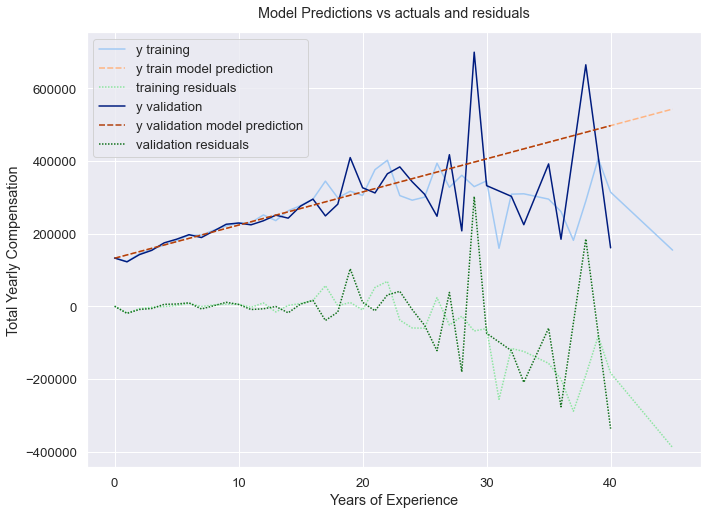

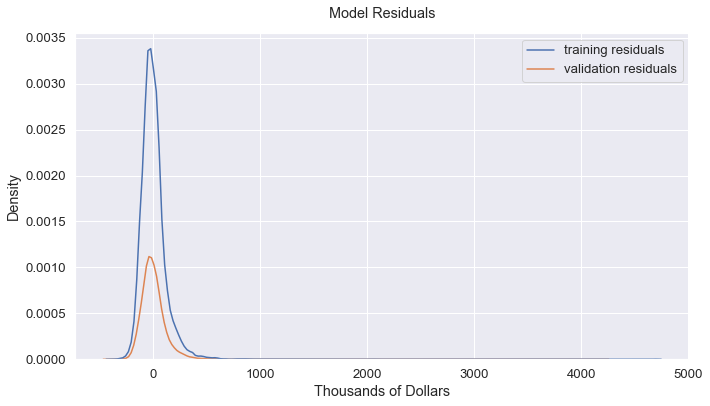

In [14]:
x_train = traindf["yearsofexperience"]
y_train = traindf["totalyearlycompensation"]
x_val = validatedf["yearsofexperience"]
y_val = validatedf["totalyearlycompensation"]

eval_envir(x_train, y_train, x_val, y_val)

# Model development

To build our model, we slowly added more and more variables from our dataset to the regression to see how it improved. For all the categorical variables, we simply made dummies for a given variable, looked at the output, then removed the dummies that had  statistically insiginificant p-values for their coefficients. We'll now show how that model incrementally improved.

> First, we added our baseline, performed a feature transformation on our baseline, and added years an employee had been at a company to the model:

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.171
Model:                                 OLS   Adj. R-squared:                  0.171
Method:                      Least Squares   F-statistic:                     888.6
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:36   Log-Likelihood:            -1.6908e+05
No. Observations:                    12891   AIC:                         3.382e+05
Df Residuals:                        12887   BIC:                         3.382e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.218e+05   2205.692     55.211      0.000    1.17e+05    1.26e+05
yearsofexperience    1.394e+04    498.149     27.978      0.000     1.3e+04    1.49e+04
yearsofexperiencesq  -183.5278     20.880     -8.790      0.000    -224.456    -142.599
yearsatcompany      -2901.3359    379.497     -7.645      0.000   -3645.207   -2157.465
==============================================================================
Omnibus:                    16612.640   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19550357.560
Skew:                           6.438   Prob(JB):                         0.00
Kurtosis:                     193.348   Cond. No.                         339.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.171407,0.160232,0.154076
Mean absolute error,79878.314158,79521.811512,80032.571326
Root mean squared error,120202.616884,125521.830114,125982.987618
Mean Relative Error,0.692377,0.699716,0.706859


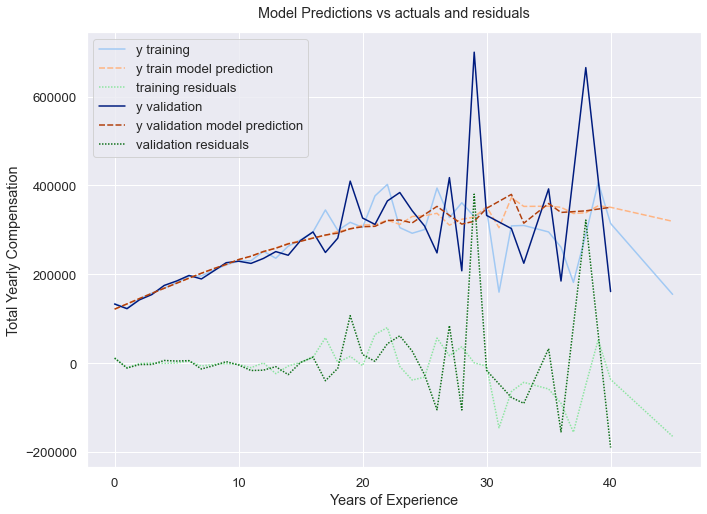

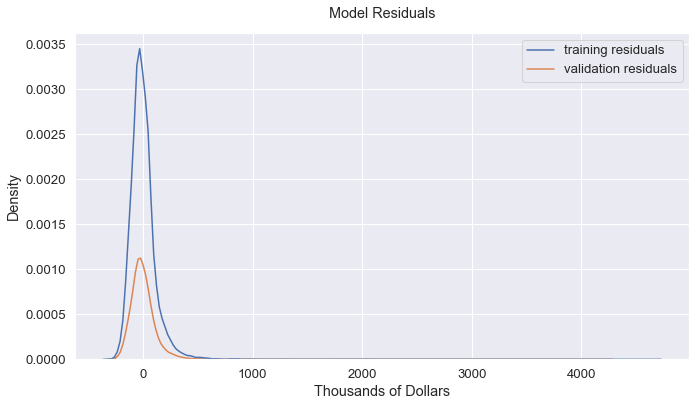

In [15]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()

    return x

y_val = validatedf["totalyearlycompensation"]
y_train = traindf["totalyearlycompensation"]

eval_envir(preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val)

> Next, we added dummy variables to account for an employee's education and job title.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.225
Model:                                 OLS   Adj. R-squared:                  0.224
Method:                      Least Squares   F-statistic:                     249.3
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:36   Log-Likelihood:            -1.6864e+05
No. Observations:                    12891   AIC:                         3.373e+05
Df Residuals:                        12875   BIC:                         3.374e+05
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          1.16e+05   2294.799     50.530      0.000    1.11e+05     1.2e+05
yearsofexperience             1.224e+04    491.447     24.915      0.000    1.13e+04    1.32e+04
yearsofexperiencesq           -151.2119     20.330     -7.438      0.000    -191.062    -111.361
yearsatcompany               -2991.5816    369.168     -8.104      0.000   -3715.206   -2267.957
Master's Degree               2.399e+04   2159.509     11.108      0.000    1.98e+04    2.82e+04
PhD                           1.036e+05   5251.900     19.723      0.000    9.33e+04    1.14e+05
Business Analyst              -5.31e+04   7133.519     -7.443      0.000   -6.71e+04   -3.91e+04
Data Scientist               -1.797e+04   5398.094     -3.328      0.001   -2.85e+04   -7384.329
Hardware Engineer            -2.016e+04   5439.989     -3.705      0.000   -3.08e+04   -9492.886
Human Resources              -4.596e+04   1.24e+04     -3.700      0.000   -7.03e+04   -2.16e+04
Management Consultant        -4.034e+04   7215.360     -5.591      0.000   -5.45e+04   -2.62e+04
Marketing                    -1.497e+04   8064.891     -1.856      0.064   -3.08e+04     842.716
Mechanical Engineer          -2.934e+04   9521.458     -3.082      0.002    -4.8e+04   -1.07e+04
Product Manager               2.942e+04   4179.644      7.040      0.000    2.12e+04    3.76e+04
Recruiter                     -4.35e+04   1.02e+04     -4.283      0.000   -6.34e+04   -2.36e+04
Software Engineering Manager  7.643e+04   5073.836     15.063      0.000    6.65e+04    8.64e+04
==============================================================================
Omnibus:                    17092.811   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23975035.789
Skew:                           6.763   Prob(JB):                         0.00
Kurtosis:                     213.839   Cond. No.                     1.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.225103,0.204535,0.154076
Mean absolute error,76194.917701,76031.675303,80032.571326
Root mean squared error,116242.584284,122167.427902,125982.987618
Mean Relative Error,0.650502,0.665868,0.706859


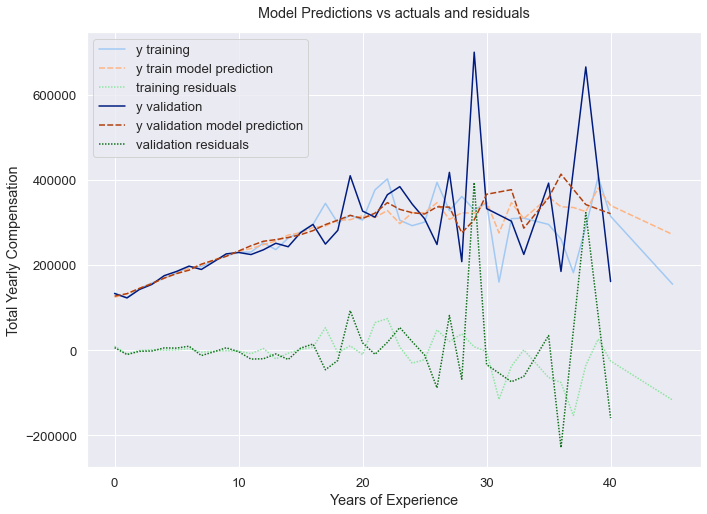

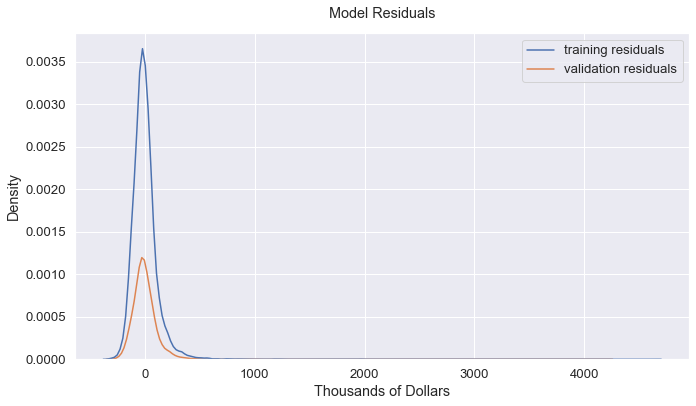

In [16]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    #variables for education, notice the variables droped from the list (i.e. "Bachelor's Degree", "Some College", ...etc.)
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    #varaibles for job title, notice the variables droped from the list (i.e. 'Software Engineer', 'Sales', ...etc.)
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    
    
    return x

#evaluation metrics
y_train = traindf["totalyearlycompensation"]

eval_envir(preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val)

In [17]:
clean["state or country"].unique()

array(['CA', 'WA', 'TX', 'Canada', 'India', 'Netherlands', 'AZ', 'NY',
       'IL', 'MA', 'NC', 'VA', 'CO', 'United Kingdom', 'FL', 'WI',
       'Hong Kong (SAR)', 'China', 'DC', 'Ireland', 'OR', 'MI', 'MN',
       'MO', 'Germany', 'Russia', 'PA', 'Israel', 'Singapore', 'UT', 'NJ',
       'TN', 'Czech Republic', 'LA', 'France', 'GA', 'Japan', 'AR',
       'Switzerland', 'Poland', 'IA', 'Brazil', 'Australia', 'OH', 'MD',
       'Spain', 'IN', 'Ukraine', 'Italy', 'MT', 'RI', 'DE', 'Romania',
       'OK', 'NV', 'CT', 'South Africa', 'AL', 'SC', 'Hungary', 'Serbia',
       'Portugal', 'KS', 'Indonesia', 'Moldova', 'Taiwan', 'Malaysia',
       'KY', 'United Arab Emirates', 'Sweden', 'New Zealand',
       'Saudi Arabia', 'WV', 'Argentina', 'Peru', 'Philippines', 'Norway',
       'Estonia', 'Belarus', 'Mexico', 'Austria', 'Korea, South',
       'Finland', 'MS', 'Vietnam', 'ID', 'NE', 'Qatar', 'Luxembourg',
       'Costa Rica', 'Colombia', 'Slovakia', 'HI', 'Denmark', 'Belgium',
       'NH', '

> Next, we added dummies to account for an employee's state or country in which they work and also the company they work for.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.498
Model:                                 OLS   Adj. R-squared:                  0.495
Method:                      Least Squares   F-statistic:                     208.4
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:37   Log-Likelihood:            -1.6585e+05
No. Observations:                    12891   AIC:                         3.318e+05
Df Residuals:                        12829   BIC:                         3.323e+05
Df Model:                               61                                         
Covariance Type:                 nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.801e+04   2708.218     21.418      0.000    5.27e+04    6.33e+04
yearsofexperience             1.178e+04    400.867     29.391      0.000     1.1e+04    1.26e+04
yearsofexperiencesq           -160.7924     16.548     -9.717      0.000    -193.229    -128.356
yearsatcompany               -1097.7317    306.704     -3.579      0.000   -1698.918    -496.546
Master's Degree               9808.2572   1786.772      5.489      0.000    6305.917    1.33e+04
PhD                           5.354e+04   4313.991     12.411      0.000    4.51e+04     6.2e+04
Business Analyst               -4.8e+04   5789.201     -8.291      0.000   -5.93e+04   -3.66e+04
Data Scientist               -7691.7887   4385.498     -1.754      0.079   -1.63e+04     904.441
Hardware Engineer             -1.53e+04   4801.502     -3.186      0.001   -2.47e+04   -5886.967
Human Resources              -5.977e+04      1e+04     -5.949      0.000   -7.95e+04   -4.01e+04
Management Consultant        -9917.1007   6453.869     -1.537      0.124   -2.26e+04    2733.444
Marketing                    -4.442e+04   6532.786     -6.800      0.000   -5.72e+04   -3.16e+04
Mechanical Engineer          -4.211e+04   7735.166     -5.444      0.000   -5.73e+04   -2.69e+04
Product Manager               2.009e+04   3396.472      5.915      0.000    1.34e+04    2.67e+04
Recruiter                    -8.118e+04   8229.420     -9.865      0.000   -9.73e+04    -6.5e+04
Software Engineering Manager  7.608e+04   4112.481     18.501      0.000     6.8e+04    8.41e+04
CA                            9.819e+04   2643.525     37.144      0.000     9.3e+04    1.03e+05
CO                            5.145e+04   9054.174      5.682      0.000    3.37e+04    6.92e+04
DC                            4.559e+04   8746.150      5.213      0.000    2.84e+04    6.27e+04
IL                            4.032e+04   6843.930      5.892      0.000    2.69e+04    5.37e+04
MA                            4.376e+04   5875.362      7.447      0.000    3.22e+04    5.53e+04
NJ                            4.303e+04   1.04e+04      4.122      0.000    2.26e+04    6.35e+04
NY                            7.711e+04   3728.217     20.683      0.000    6.98e+04    8.44e+04
OR                            4.694e+04   8705.251      5.392      0.000    2.99e+04     6.4e+04
TX                            2.666e+04   4122.854      6.466      0.000    1.86e+04    3.47e+04
VA                            3.911e+04   7055.981      5.542      0.000    2.53e+04    5.29e+04
WA                             7.91e+04   3256.709     24.289      0.000    7.27e+04    8.55e+04
India                        -7.383e+04   3795.608    -19.452      0.000   -8.13e+04   -6.64e+04
Israel               

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.497668,0.442633,0.154076
Mean absolute error,54444.510078,55630.421255,80032.571326
Root mean squared error,93592.054803,102262.801794,125982.987618
Mean Relative Error,0.337943,0.358171,0.706859


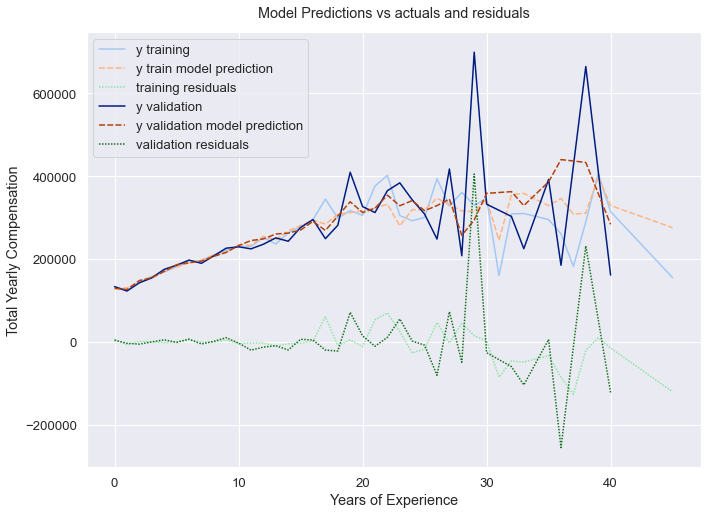

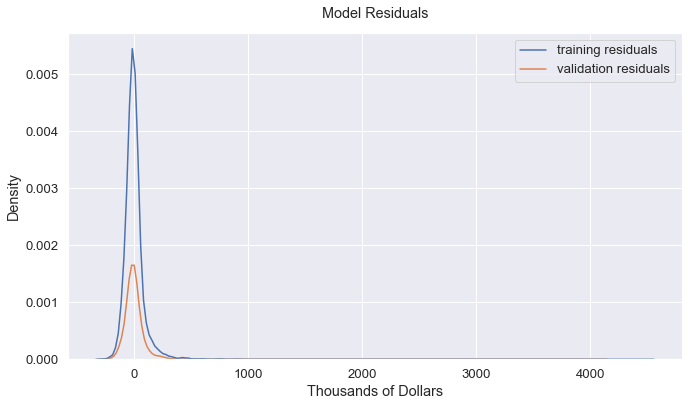

In [18]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    #variables for education, notice the variables droped from the list (i.e. "Bachelor's Degree", "Some College", ...etc.)
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    #varaibles for job titles, notice the variables droped from the list (i.e. 'Software Engineer', 'Sales', ...etc.)
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    #variables for country or state, notice the varaibles dropped from the list (i.e. "CA", "CO", ...etc.)
    x = x.join(pd.get_dummies(featurevectors['state or country'])[["CA", "CO", "DC", "IL","MA",
                                                                   "NJ","NY","OR","TX","VA","WA", 
                                                                   "India", "Israel", "Poland", 
                                                                   "Russia", "Spain", "Sweden", 
                                                                   "Canada",
                                                                   "Switzerland", "Taiwan"]])
    
    #creating a list of the top 20 most common companies in the data set to use as variables
    top20companies = list(featurevectors["company"].value_counts().head(30).index)
    top20companies.append("Netflix")
    
    #using the list of the top 20 companies as the varaiables, notice the varaiables dropped (i.e. 'PayPal', 'Goldman Sachs', ...etc.)
    x = x.join(pd.get_dummies(featurevectors["company"])[top20companies].drop(columns = ['PayPal',
                                                                                        'Goldman Sachs',
                                                                                        'VMware',
                                                                                        'Intuit', 'Walmart Labs']))
    
    
    return x

y_train = traindf["totalyearlycompensation"]

eval_envir(preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val)

> Next, since we know that the distibution of our target variable looks like a power law distribution, we tried performing a log tranformation on our y values. To do so, we need to modify the base model in our evaluation environment.

In [19]:
def eval_envir(x_train, y_train, x_val, y_val):
    
    #transforming our y values to logs
    log_y_train = np.log(y_train)
    log_y_val = np.log(y_val)
    
    #creating the model
    x1 = x_train
    x = sm.add_constant(x1)
    model = sm.OLS(y_train,x).fit()
    model = sm.OLS(log_y_train,x).fit()
    display(model.summary())
    
    #Have to revert the log transformation on the x values now with np.exp()
    x_train_predictions = np.exp(model.predict(x))
    x_val_with_constant = sm.add_constant(x_val)
    x_val_predictions = np.exp(model.predict(x_val_with_constant))
    
    
    #creating a dataframe to put our evaluation metrics into
    modelmetricstrain = pd.Series({"Coefficient of determination": y_train.corr(x_train_predictions)**2,
    "Mean absolute error" : meanabs(y_train, x_train_predictions),
    "Root mean squared error" : rmse(y_train, x_train_predictions),
    "Mean Relative Error" : mre(y_train, x_train_predictions)})
    
    modelmetricsval = pd.Series({"Coefficient of determination": y_val.corr(x_val_predictions)**2,
    "Mean absolute error" : meanabs(y_val, x_val_predictions),
    "Root mean squared error" : rmse(y_val, x_val_predictions),
    "Mean Relative Error" : mre(y_val, x_val_predictions)})
    
    modelmetricbaselines = pd.Series({"Coefficient of determination": 0.154076,
    "Mean absolute error" : 80032.571326,
    "Root mean squared error" : 125982.987618,
    "Mean Relative Error" : 0.706859})
    
    metricsdf = pd.DataFrame(modelmetricstrain)
    metricsdf["Evaluation Metrics on validation data"] = modelmetricsval
    metricsdf.rename(columns = {0: "Evaluation Metrics on training data"}, inplace = True)
    metricsdf["validation baselines"] = modelmetricbaselines
    display(metricsdf)
    

    #creating dataframes to be graphed
    df1 = pd.DataFrame()
    df1["y training"] = y_train
    df1["y train model prediction"] = x_train_predictions
    df1["Years of Experience"] = x["yearsofexperience"]
    df1['training residuals'] = df1['y training'] - df1['y train model prediction']
    df1.index = df1["Years of Experience"]
    df1 = df1.drop(columns = "Years of Experience")
    df1
    

    df2 = pd.DataFrame()
    df2["y validation"] = y_val
    df2["y validation model prediction"] = x_val_predictions
    x_val = sm.add_constant(x_val) #constant added just to make x_val a df
    df2["Years of Experience"] = x_val["yearsofexperience"]
    df2['validation residuals'] = df2['y validation'] - df2['y validation model prediction']
    df2.index = df2["Years of Experience"]
    df2 = df2.drop(columns = "Years of Experience")
    df2

    #graphing residuals and predictions
    sns.set(rc = {'figure.figsize':(11,8)})
    sns.set_theme(font_scale = 1.2)
    regplot1 = sns.lineplot(data = df1, ci = None, palette = 'pastel')
    regplot1.set_title("Model Predictions vs actuals and residuals", pad = 15)
    regplot1.set_ylabel("Total Yearly Compensation")
    regplot2 = sns.lineplot(data = df2, ci = None, palette = 'dark')
    plt.show()
    
    
    #graphing residual distributions
    residdf = df1['training residuals'].reset_index().drop(columns = "Years of Experience").copy()
    residdf["validation residuals"] = df2['validation residuals'].reset_index().drop(columns = "Years of Experience").copy()
    
    sns.set(rc = {'figure.figsize':(11,6)})
    sns.set_theme(font_scale = 1.2)
    residgraph = sns.kdeplot(data = residdf/1000)
    residgraph.set_title("Model Residuals", pad = 15)
    residgraph.set_xlabel("Thousands of Dollars")
    plt.show()
    
    #return residuals such that analysis can be conducted on the residuals
    return residdf
    
    

> Now we run it on our model from the previous cell.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.707
Model:                                 OLS   Adj. R-squared:                  0.706
Method:                      Least Squares   F-statistic:                     499.3
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:38   Log-Likelihood:                -4933.9
No. Observations:                    12891   AIC:                             9994.
Df Residuals:                        12828   BIC:                         1.046e+04
Df Model:                               62                                         
Covariance Type:                 nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           11.2713      0.010   1097.511      0.000      11.251      11.291
yearsofexperience                0.0707      0.002     46.516      0.000       0.068       0.074
yearsofexperiencesq             -0.0014   6.27e-05    -22.752      0.000      -0.002      -0.001
yearsatcompany                  -0.0070      0.001     -5.996      0.000      -0.009      -0.005
Master's Degree                  0.0619      0.007      9.144      0.000       0.049       0.075
PhD                              0.2353      0.016     14.384      0.000       0.203       0.267
Business Analyst                -0.3177      0.022    -14.474      0.000      -0.361      -0.275
Data Scientist                  -0.0041      0.017     -0.246      0.806      -0.037       0.029
Hardware Engineer               -0.0589      0.018     -3.237      0.001      -0.095      -0.023
Human Resources                 -0.3010      0.038     -7.904      0.000      -0.376      -0.226
Management Consultant           -0.0174      0.024     -0.712      0.476      -0.065       0.031
Marketing                       -0.2395      0.025     -9.669      0.000      -0.288      -0.191
Mechanical Engineer             -0.2211      0.029     -7.539      0.000      -0.279      -0.164
Product Manager                  0.0518      0.013      4.019      0.000       0.027       0.077
Recruiter                       -0.3815      0.031    -12.227      0.000      -0.443      -0.320
Software Engineering Manager     0.2523      0.016     16.181      0.000       0.222       0.283
CA                               0.5433      0.010     54.191      0.000       0.524       0.563
CO                               0.3188      0.034      9.286      0.000       0.251       0.386
DC                               0.3230      0.033      9.742      0.000       0.258       0.388
IL                               0.2700      0.026     10.407      0.000       0.219       0.321
MA                               0.3226      0.022     14.484      0.000       0.279       0.366
NJ                               0.3008      0.040      7.589      0.000       0.223       0.378
NY                               0.4729      0.014     33.455      0.000       0.445       0.501
OR                               0.3289      0.033      9.966      0.000       0.264       0.394
TX                               0.2105      0.016     13.471      0.000       0.180       0.241
VA                               0.2773      0.027     10.368      0.000       0.225       0.330
WA                               0.4474      0.012     36.234      0.000       0.423       0.472
India                           -0.9542      0.014    -66.221      0.000      -0.982      -0.926
Israel               

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.518573,0.459774,0.154076
Mean absolute error,50680.549311,52043.911141,80032.571326
Root mean squared error,92277.402047,101289.717605,125982.987618
Mean Relative Error,0.278866,0.296303,0.706859


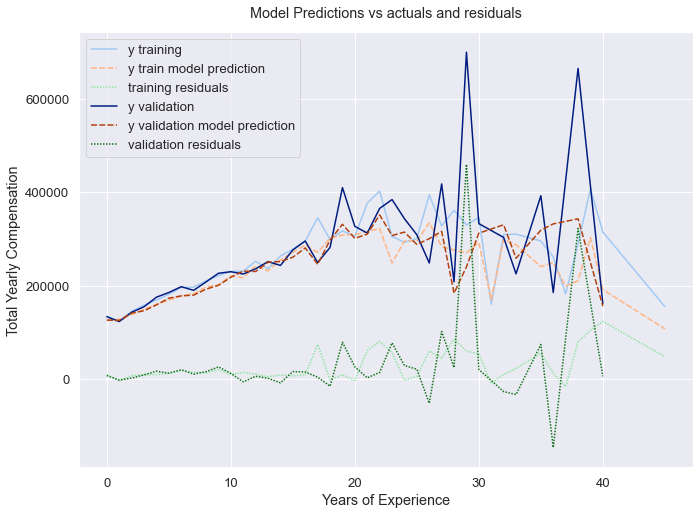

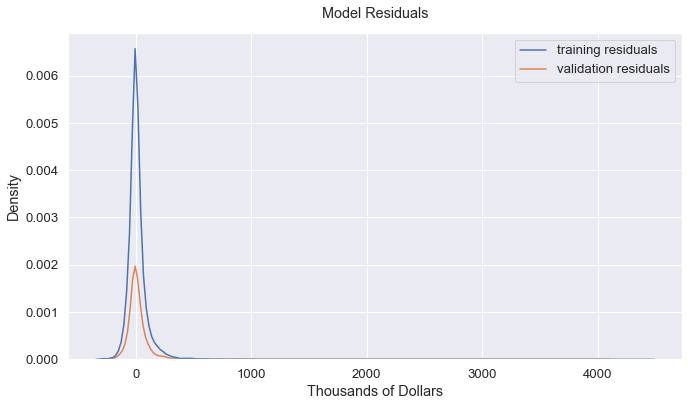

In [20]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    
    
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    x = x.join(pd.get_dummies(featurevectors['state or country'])[["CA", "CO", "DC", "IL","MA",
                                                                   "NJ","NY","OR","TX","VA","WA", 
                                                                   "India", "Israel", "Poland", 
                                                                   "Russia", "Spain", "Sweden","Canada", 
                                                                   "Switzerland", "Taiwan"]])
    
    top20companies = list(featurevectors["company"].value_counts().head(30).index)
    top20companies.append("Netflix")
    
    x = x.join(pd.get_dummies(featurevectors["company"])[top20companies].drop(columns = ['PayPal',
                                                                                        'Goldman Sachs',
                                                                                        'VMware',
                                                                                        'Intuit']))
    
    
    
    return x

eval_envir(preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val);

Our metrics improved every so slightly.

> Lets try scaling our x values then.

In [21]:
def scalex(xdf):
    scaler = preprocessing.StandardScaler().fit(xdf)
    scaled_x_train = scaler.transform(xdf)
    scaled_x_train = pd.DataFrame(scaled_x_train)
    scaled_x_train.columns = xdf.columns
    return scaled_x_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.707
Model:                                 OLS   Adj. R-squared:                  0.706
Method:                      Least Squares   F-statistic:                     499.3
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:22:39   Log-Likelihood:                -4933.9
No. Observations:                    12891   AIC:                             9994.
Df Residuals:                        12828   BIC:                         1.046e+04
Df Model:                               62                                         
Covariance Type:                 nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.0042      0.003   3832.030      0.000      11.998      12.010
yearsofexperience                0.4130      0.009     46.516      0.000       0.396       0.430
yearsofexperiencesq             -0.1933      0.008    -22.752      0.000      -0.210      -0.177
yearsatcompany                  -0.0230      0.004     -5.996      0.000      -0.030      -0.015
Master's Degree                  0.0306      0.003      9.144      0.000       0.024       0.037
PhD                              0.0482      0.003     14.384      0.000       0.042       0.055
Business Analyst                -0.0458      0.003    -14.474      0.000      -0.052      -0.040
Data Scientist                  -0.0008      0.003     -0.246      0.806      -0.007       0.006
Hardware Engineer               -0.0113      0.004     -3.237      0.001      -0.018      -0.004
Human Resources                 -0.0249      0.003     -7.904      0.000      -0.031      -0.019
Management Consultant           -0.0025      0.003     -0.712      0.476      -0.009       0.004
Marketing                       -0.0306      0.003     -9.669      0.000      -0.037      -0.024
Mechanical Engineer             -0.0239      0.003     -7.539      0.000      -0.030      -0.018
Product Manager                  0.0129      0.003      4.019      0.000       0.007       0.019
Recruiter                       -0.0387      0.003    -12.227      0.000      -0.045      -0.032
Software Engineering Manager     0.0534      0.003     16.181      0.000       0.047       0.060
CA                               0.2505      0.005     54.191      0.000       0.241       0.260
CO                               0.0298      0.003      9.286      0.000       0.024       0.036
DC                               0.0326      0.003      9.742      0.000       0.026       0.039
IL                               0.0341      0.003     10.407      0.000       0.028       0.041
MA                               0.0529      0.004     14.484      0.000       0.046       0.060
NJ                               0.0243      0.003      7.589      0.000       0.018       0.031
NY                               0.1259      0.004     33.455      0.000       0.119       0.133
OR                               0.0346      0.003      9.966      0.000       0.028       0.041
TX                               0.0476      0.004     13.471      0.000       0.041       0.055
VA                               0.0362      0.003     10.368      0.000       0.029       0.043
WA                               0.1656      0.005     36.234      0.000       0.157       0.175
India                           -0.2438      0.004    -66.221      0.000      -0.251      -0.237
Israel               

,Evaluation Metrics on training data,Evaluation Metrics on validation data,validation baselines
Coefficient of determination,0.518573,0.462298,0.154076
Mean absolute error,50680.549311,52131.695162,80032.571326
Root mean squared error,92277.402047,100926.884770,125982.987618
Mean Relative Error,0.278866,0.297708,0.706859


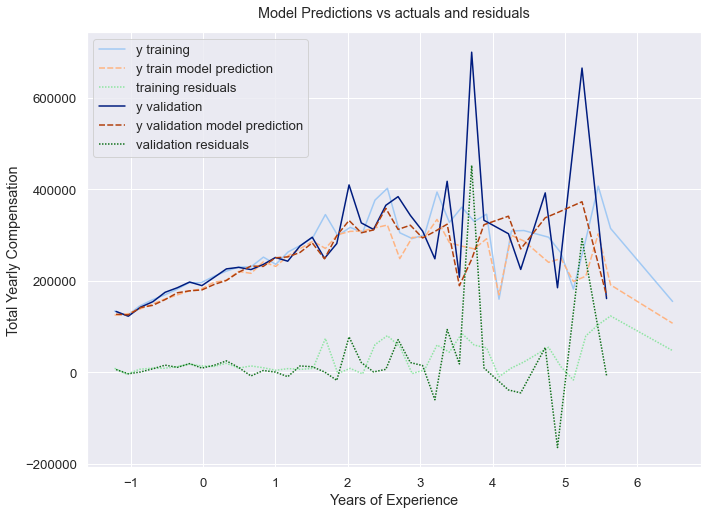

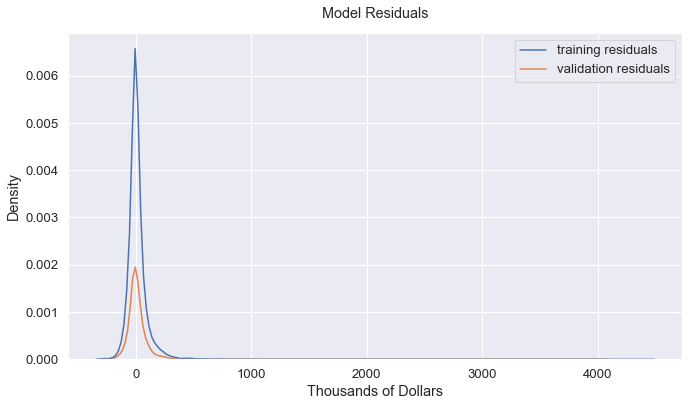

,training residuals,validation residuals
0,56603.745938,30327.392151
1,216083.646421,8801.603499
2,23111.332992,-353.337365
3,239179.464659,69392.716215
4,3687.135697,127461.352366
...,...,...
12886,15534.324466,NaN
12887,20435.092829,NaN
12888,-54796.347168,NaN
12889,-13842.657485,NaN


In [22]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    x = x.join(pd.get_dummies(featurevectors['state or country'])[["CA", "CO", "DC", "IL","MA",
                                                                   "NJ","NY","OR","TX","VA","WA", 
                                                                   "India", "Israel", "Poland", 
                                                                   "Russia", "Spain", "Sweden",
                                                                   "Canada",
                                                                   "Switzerland", "Taiwan"]])
    
    top20companies = list(featurevectors["company"].value_counts().head(30).index)
    top20companies.append("Netflix")
    
    x = x.join(pd.get_dummies(featurevectors["company"])[top20companies].drop(columns = ['PayPal',
                                                                                        'Goldman Sachs',
                                                                                        'VMware',
                                                                                        'Intuit']))
    
    x = scalex(x)
    
    return x

#have to do all this reset index nonsense to get the indexs to work in the model
eval_envir(preprocess_x(traindf), y_train.reset_index().drop(columns = "index")["totalyearlycompensation"], 
           preprocess_x(validatedf), y_val.reset_index().drop(columns = "index")["totalyearlycompensation"])

Little change or improvement, so we will just stick with the last model before we applied a standard scaler to the feature vectors.

> Next we turned to some other forms of regression models.

In [23]:
def eval_envir2(model, x_train, y_train, x_val, y_val):
    log_y_train = np.log(y_train)
    log_y_val = np.log(y_val)
    
    model.fit(x_train, log_y_train)
    y_train_pred = np.exp(model.predict(x_train))
    y_val_pred = np.exp(model.predict(x_val))
    
    modelmetricsval = pd.Series({"Coefficient of determination": r2_score(y_val, y_val_pred),
    "Mean absolute error" : mean_absolute_error(y_val, y_val_pred),
    "Root mean squared error" : mean_squared_error(y_val, y_val_pred, squared = False),
    "Mean Relative Error" : mre(y_val, y_val_pred)})
    
    return modelmetricsval

In [24]:
zoo = {
    "DT" : DecisionTreeRegressor(),
    "SVR" : SVR(),
    'KNN' : KNeighborsRegressor(n_neighbors= 3),
    "NM": MLPRegressor((20,20))
}

> First we will do the models on just years of experience and compare that to our baseline.

In [25]:
df = pd.DataFrame(pd.Series({"Coefficient of determination": 0.154076,
                             "Mean absolute error" : 80032.571326,
                             "Root mean squared error" : 125982.987618,
                             "Mean Relative Error" : 0.545718}))
df = df.rename(columns = {0: "Linear regression baseline"})

def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    return x

for model in zoo:
    regression = zoo[model]
    df[model] = eval_envir2(regression, preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val)

display(df)

,Linear regression baseline,DT,SVR,KNN,NM
Coefficient of determination,0.154076,0.114668,0.134663,0.001266,0.083478
Mean absolute error,80032.571326,79073.050540,78224.016362,87341.771336,79666.425736
Root mean squared error,125982.987618,128880.369827,127416.697571,136885.822452,131130.882950
Mean Relative Error,0.545718,0.600418,0.644331,0.730471,0.592479


None of them seem to perform very well compared to our linear model, but let's try tuning the training data a little bit.

> Next we scale our X-values.

In [26]:
df = pd.DataFrame(pd.Series({"Coefficient of determination": 0.154076,
                             "Mean absolute error" : 80032.571326,
                             "Root mean squared error" : 125982.987618,
                             "Mean Relative Error" : 0.545718}))
df = df.rename(columns = {0: "Linear regression baseline"})

def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    return x

for model in zoo:
    regression = zoo[model]
    df[model] = eval_envir2(regression, scalex(preprocess_x(traindf)), y_train, scalex(preprocess_x(validatedf)), y_val)

df

,Linear regression baseline,DT,SVR,KNN,NM
Coefficient of determination,0.154076,0.114668,0.134857,-0.043792,0.112537
Mean absolute error,80032.571326,79073.050540,78233.012875,89412.127113,78642.653837
Root mean squared error,125982.987618,128880.369827,127402.397817,139939.583010,129035.389333
Mean Relative Error,0.545718,0.600418,0.645520,0.653226,0.616021


Looks like scaling the data improved the models.

> Next we try including all the preprocessing we did for the linear model.

In [27]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    x = x.join(pd.get_dummies(featurevectors['state or country'])[["CA", "CO", "DC", "IL","MA",
                                                                   "NJ","NY","OR","TX","VA","WA", 
                                                                   "India", "Israel", "Poland", 
                                                                   "Russia", "Spain", "Sweden", "Canada", 
                                                                   "Switzerland", "Taiwan"]])
    
    top20companies = list(featurevectors["company"].value_counts().head(30).index)
    top20companies.append("Netflix")
    
    x = x.join(pd.get_dummies(featurevectors["company"])[top20companies].drop(columns = ['PayPal',
                                                                                        'Goldman Sachs',
                                                                                        'VMware',
                                                                                        'Intuit']))
    
    x = scalex(x)
    
    return x


df = pd.DataFrame(pd.Series({"Coefficient of determination": 0.154076,
                             "Mean absolute error" : 80032.571326,
                             "Root mean squared error" : 125982.987618,
                             "Mean Relative Error" : 0.545718}))
df = df.rename(columns = {0: "Linear regression baseline"})

for model in zoo:
    regression = zoo[model]
    df[model] = eval_envir2(regression, preprocess_x(traindf), y_train, preprocess_x(validatedf), y_val)

df

,Linear regression baseline,DT,SVR,KNN,NM
Coefficient of determination,0.154076,0.248545,0.465665,0.368951,-2.701704
Mean absolute error,80032.571326,64601.807169,52307.614728,60484.542803,81651.041368
Root mean squared error,125982.987618,118736.738735,100124.472917,108809.100320,263532.660668
Mean Relative Error,0.545718,0.367260,0.308976,0.358346,0.470628


The evaluation metrics for the neural network are almost as good as the final linear regression model, but the metrics for all the other models either didn't improve enough to be as good as the linear model or worse than they were in the last cell. Even though the nueral network model performed pretty well compared to the other models, it still is outperformed on the validation data by the linear model.

> Then we run the final linear model on the testing data.

In [28]:
#changing some of the values in the plots to be testing instead of validation
def eval_envir(x_train, y_train, x_val, y_val):
    
    #transforming our y values to logs
    log_y_train = np.log(y_train)
    log_y_val = np.log(y_val)
    
    #creating the model
    x1 = x_train
    x = sm.add_constant(x1)
    model = sm.OLS(y_train,x).fit()
    model = sm.OLS(log_y_train,x).fit()
    display(model.summary())
    
    #Have to revert the log transformation on the x values now with np.exp()
    x_train_predictions = np.exp(model.predict(x))
    x_val_with_constant = sm.add_constant(x_val)
    x_val_predictions = np.exp(model.predict(x_val_with_constant))
    
    
    #creating a dataframe to put our evaluation metrics into
    modelmetricstrain = pd.Series({"Coefficient of determination": y_train.corr(x_train_predictions)**2,
    "Mean absolute error" : meanabs(y_train, x_train_predictions),
    "Root mean squared error" : rmse(y_train, x_train_predictions),
    "Mean Relative Error" : mre(y_train, x_train_predictions)})
    
    modelmetricsval = pd.Series({"Coefficient of determination": y_val.corr(x_val_predictions)**2,
    "Mean absolute error" : meanabs(y_val, x_val_predictions),
    "Root mean squared error" : rmse(y_val, x_val_predictions),
    "Mean Relative Error" : mre(y_val, x_val_predictions)})
    
    modelmetricbaselines = pd.Series({"Coefficient of determination": 0.154076,
    "Mean absolute error" : 80032.571326,
    "Root mean squared error" : 125982.987618,
    "Mean Relative Error" : 0.706859})
    
    metricsdf = pd.DataFrame(modelmetricstrain)
    metricsdf["Evaluation Metrics on test data"] = modelmetricsval
    metricsdf.rename(columns = {0: "Evaluation Metrics on training data"}, inplace = True)
    metricsdf["validation baselines"] = modelmetricbaselines
    display(metricsdf)
    

    #creating dataframes to be graphed
    df1 = pd.DataFrame()
    df1["y training"] = y_train
    df1["y train model prediction"] = x_train_predictions
    df1["Years of Experience"] = x["yearsofexperience"]
    df1['training residuals'] = df1['y training'] - df1['y train model prediction']
    df1.index = df1["Years of Experience"]
    df1 = df1.drop(columns = "Years of Experience")
    df1
    

    df2 = pd.DataFrame()
    df2["y test"] = y_val
    df2["y test model prediction"] = x_val_predictions
    x_val = sm.add_constant(x_val) #constant added just to make x_val a df
    df2["Years of Experience"] = x_val["yearsofexperience"]
    df2['test residuals'] = df2['y test'] - df2['y test model prediction']
    df2.index = df2["Years of Experience"]
    df2 = df2.drop(columns = "Years of Experience")
    df2

    #graphing residuals and predictions
    sns.set(rc = {'figure.figsize':(11,8)})
    sns.set_theme(font_scale = 1.2)
    regplot1 = sns.lineplot(data = df1, ci = None, palette = 'pastel')
    regplot1.set_title("Model Predictions vs actuals and residuals", pad = 15)
    regplot1.set_ylabel("Total Yearly Compensation")
    regplot2 = sns.lineplot(data = df2, ci = None, palette = 'dark')
    plt.show()
    
    
    #graphing residual distributions
    residdf = df1['training residuals'].reset_index().drop(columns = "Years of Experience").copy()
    residdf["test residuals"] = df2['test residuals'].reset_index().drop(columns = "Years of Experience").copy()
    
    sns.set(rc = {'figure.figsize':(11,6)})
    sns.set_theme(font_scale = 1.2)
    residgraph = sns.kdeplot(data = residdf, log_scale = True)
    residgraph.set_title("Model Residuals", pad = 15)
    residgraph.set_xlabel("Dollars")
    plt.show()
    
    #return residuals such that analysis can be conducted on the residuals
    return residdf
    
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     totalyearlycompensation   R-squared:                       0.707
Model:                                 OLS   Adj. R-squared:                  0.706
Method:                      Least Squares   F-statistic:                     499.3
Date:                     Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                             21:24:17   Log-Likelihood:                -4933.9
No. Observations:                    12891   AIC:                             9994.
Df Residuals:                        12828   BIC:                         1.046e+04
Df Model:                               62                                         
Covariance Type:                 nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           11.2713      0.010   1097.511      0.000      11.251      11.291
yearsofexperience                0.0707      0.002     46.516      0.000       0.068       0.074
yearsofexperiencesq             -0.0014   6.27e-05    -22.752      0.000      -0.002      -0.001
yearsatcompany                  -0.0070      0.001     -5.996      0.000      -0.009      -0.005
Master's Degree                  0.0619      0.007      9.144      0.000       0.049       0.075
PhD                              0.2353      0.016     14.384      0.000       0.203       0.267
Business Analyst                -0.3177      0.022    -14.474      0.000      -0.361      -0.275
Data Scientist                  -0.0041      0.017     -0.246      0.806      -0.037       0.029
Hardware Engineer               -0.0589      0.018     -3.237      0.001      -0.095      -0.023
Human Resources                 -0.3010      0.038     -7.904      0.000      -0.376      -0.226
Management Consultant           -0.0174      0.024     -0.712      0.476      -0.065       0.031
Marketing                       -0.2395      0.025     -9.669      0.000      -0.288      -0.191
Mechanical Engineer             -0.2211      0.029     -7.539      0.000      -0.279      -0.164
Product Manager                  0.0518      0.013      4.019      0.000       0.027       0.077
Recruiter                       -0.3815      0.031    -12.227      0.000      -0.443      -0.320
Software Engineering Manager     0.2523      0.016     16.181      0.000       0.222       0.283
CA                               0.5433      0.010     54.191      0.000       0.524       0.563
CO                               0.3188      0.034      9.286      0.000       0.251       0.386
DC                               0.3230      0.033      9.742      0.000       0.258       0.388
IL                               0.2700      0.026     10.407      0.000       0.219       0.321
MA                               0.3226      0.022     14.484      0.000       0.279       0.366
NJ                               0.3008      0.040      7.589      0.000       0.223       0.378
NY                               0.4729      0.014     33.455      0.000       0.445       0.501
OR                               0.3289      0.033      9.966      0.000       0.264       0.394
TX                               0.2105      0.016     13.471      0.000       0.180       0.241
VA                               0.2773      0.027     10.368      0.000       0.225       0.330
WA                               0.4474      0.012     36.234      0.000       0.423       0.472
India                           -0.9542      0.014    -66.221      0.000      -0.982      -0.926
Israel               

,Evaluation Metrics on training data,Evaluation Metrics on test data,validation baselines
Coefficient of determination,0.518573,0.508351,0.154076
Mean absolute error,50680.549311,55338.110659,80032.571326
Root mean squared error,92277.402047,92921.217729,125982.987618
Mean Relative Error,0.278866,0.307711,0.706859


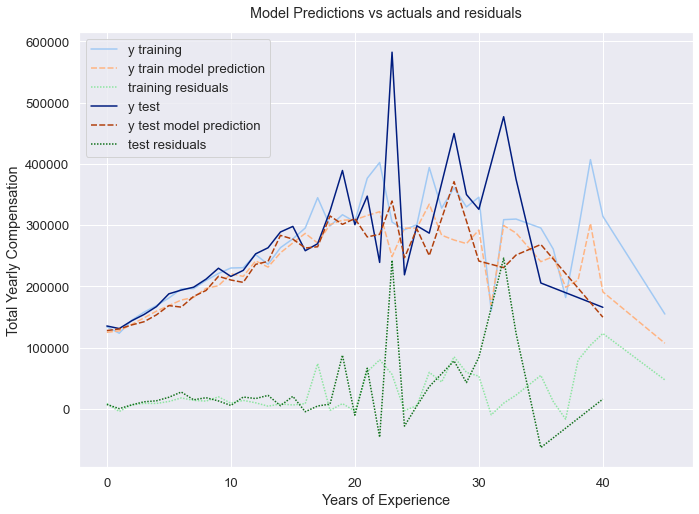

/Users/cameronkaminski/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


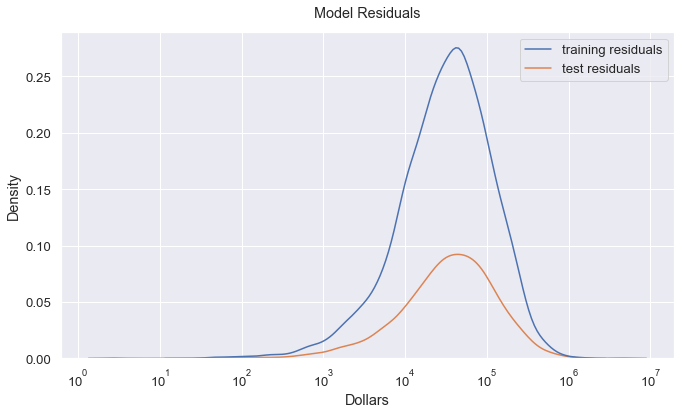

In [29]:
def preprocess_x(featurevectors):
    x = pd.DataFrame(featurevectors['yearsofexperience'].copy())
    x['yearsofexperiencesq'] = featurevectors['yearsofexperience']**2
    x['yearsatcompany'] = featurevectors['yearsatcompany'].copy()
    
    x = x.join(pd.get_dummies(featurevectors['Education']).drop(columns = ["Bachelor's Degree", 
                                                                                  "Some College","Highschool"]))
    x = x.join(pd.get_dummies(featurevectors['title']).drop(columns = ['Software Engineer',
                                                                              'Sales',
                                                                              'Product Designer', 
                                                                              'Technical Program Manager',
                                                                               'Solution Architect']))
    
    x = x.join(pd.get_dummies(featurevectors['state or country'])[["CA", "CO", "DC", "IL","MA",
                                                                   "NJ","NY","OR","TX","VA","WA", 
                                                                   "India", "Israel", "Poland", 
                                                                   "Russia", "Spain", "Sweden", 
                                                                   "Switzerland", "Taiwan", "Canada"]])
    
    top20companies = list(featurevectors["company"].value_counts().head(30).index)
    top20companies.append("Netflix")
    
    x = x.join(pd.get_dummies(featurevectors["company"])[top20companies].drop(columns = ['PayPal',
                                                                                        'Goldman Sachs',
                                                                                        'VMware',
                                                                                        'Intuit']))
    
    
    
    return x

y_train = traindf["totalyearlycompensation"]
y_test = testdf["totalyearlycompensation"]

resid = eval_envir(preprocess_x(traindf), y_train, preprocess_x(testdf), y_test)

In [30]:
resid["test residuals"].dropna()

0        -2301.583051
1       -41602.067447
2       -25951.538049
3       -17162.737459
4        23500.633291
            ...      
4292    102291.367912
4293    -52461.016603
4294     48775.459273
4295    -18999.412361
4296    167443.996875
Name: test residuals, Length: 4297, dtype: float64

In [31]:
resid.describe().round(2)

,training residuals,test residuals
count,12891.00,4297.00
mean,10727.27,13317.01
std,91655.31,91972.71
min,-305662.24,-254196.03
25%,-28986.08,-31744.34
50%,-818.38,490.81
75%,33404.00,37538.35
max,4444349.55,1167469.80


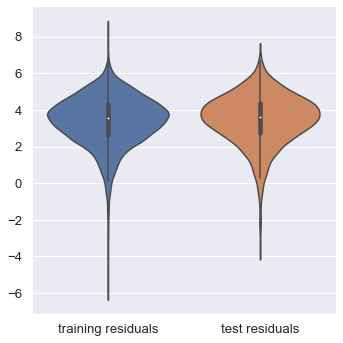

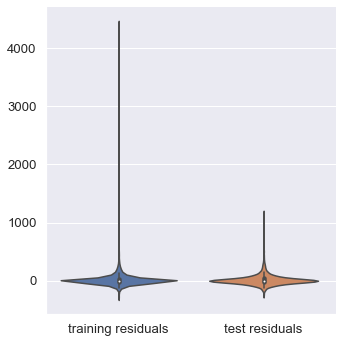

In [32]:
sns.catplot(data = np.log((resid/1000)), kind = "violin")
sns.catplot(data = (resid/1000), kind = "violin");

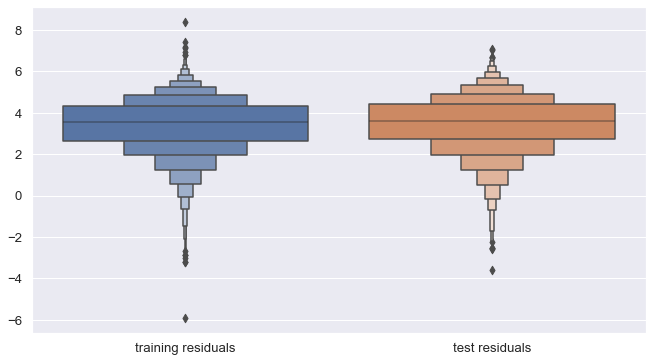

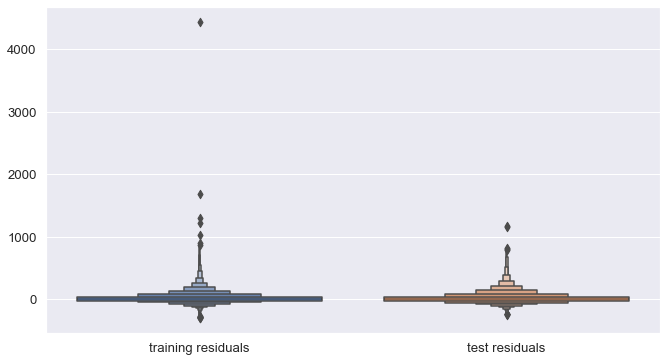

In [33]:
sns.boxenplot(data = np.log(resid/1000))
plt.show()
sns.boxenplot(data = resid/1000);

In [34]:
testresid = resid["test residuals"].dropna()
resultsdf = testdf.copy().reset_index().drop(columns = "index")
resultsdf["Prediction residuals"] = testresid
resultsdf["Prediction results"] = resultsdf["totalyearlycompensation"] + resultsdf["Prediction residuals"]
resultsdf

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,state or country,country,Prediction residuals,Prediction results
0,7/26/2021 16:29:04,Microsoft,60,Software Engineer,155000,"Seattle, WA",2.0,2.0,Web Development (Front-End),118000.0,...,1,0,0,0,White,Bachelor's Degree,WA,USA,-2301.583051,152698.416949
1,1/20/2021 19:23:15,AppDynamics,L5,Software Engineer,220000,"San Francisco, CA",11.0,1.0,Distributed Systems (Back-End),180000.0,...,1,0,0,0,White,Master's Degree,CA,USA,-41602.067447,178397.932553
2,7/28/2021 22:17:54,Tekion,L1,Product Designer,13000,"Bengaluru, KA, India",4.0,1.0,Interaction Design,13000.0,...,0,0,0,0,Asian,Bachelor's Degree,India,India,-25951.538049,-12951.538049
3,3/16/2021 13:04:20,Bloomberg,Software Engineer,Software Engineer,165000,"New York, NY",0.0,0.0,Full Stack,145000.0,...,0,0,0,0,Asian,Bachelor's Degree,NY,USA,-17162.737459,147837.262541
4,7/26/2020 21:13:00,Zillow,P3,Product Manager,220000,"Seattle, WA",7.0,1.0,Full Stack,150000.0,...,1,0,0,0,White,Bachelor's Degree,WA,USA,23500.633291,243500.633291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,1/15/2021 2:54:57,Apple,ICT4,Software Engineer,344000,"Cupertino, CA",4.0,1.0,ML / AI,195000.0,...,0,0,0,0,Asian,Master's Degree,CA,USA,102291.367912,446291.367912
4293,5/20/2021 2:58:42,Morgan Stanley,Vice President,Software Engineer,180000,"New York, NY",10.0,2.0,Testing (SDET),160000.0,...,0,0,0,0,Asian,Master's Degree,NY,USA,-52461.016603,127538.983397
4294,9/22/2020 15:10:52,Salesforce,Associate MTS,Software Engineer,168000,"Bellevue, WA",0.0,0.0,Production,130000.0,...,1,0,0,0,White,Bachelor's Degree,WA,USA,48775.459273,216775.459273
4295,6/23/2021 13:59:33,ThoughtWorks,Senior Consultant,Software Engineer,103000,"Denver, CO",2.0,2.0,Full Stack,103000.0,...,1,0,0,0,White,Bachelor's Degree,CO,USA,-18999.412361,84000.587639


***
#### Brief Look At Our Residuals

We wanted to take a quick look and check what features, or combination of features, were significantly harder for our model to predict accurately.

*(note this is not an in-depth analysis, this is simply visual aid for us to better understand what our model was doing)*

> Here we just take the absolute value of our residuals so we can judge them based on their magnitude.

In [35]:
# Taking the absolute value of all the residuals
resultsdf['residuals abs'] = abs(resultsdf["Prediction residuals"])

> Here we "scale" the values to make them more legible when graphing.

> Specifically, this is done by dividing the annual compensation and |residuals| by 1,000,000.


In [36]:
# Scaling them by 
resultsdf[['totalyearlycompensation', 'residuals abs']] = resultsdf[['totalyearlycompensation', 'residuals abs']]/ 1000000

Here we look at race. It turns out that for the most part there is no significant difference between the accuracy of our model when looking at race.
> Plotting magnitude of residuals over race, with a few alterations to make the plot more informative.

> *note the outliers automatically detected by seaborn have been removed, since we were only interested in how well the median for each category compared to the median overall.


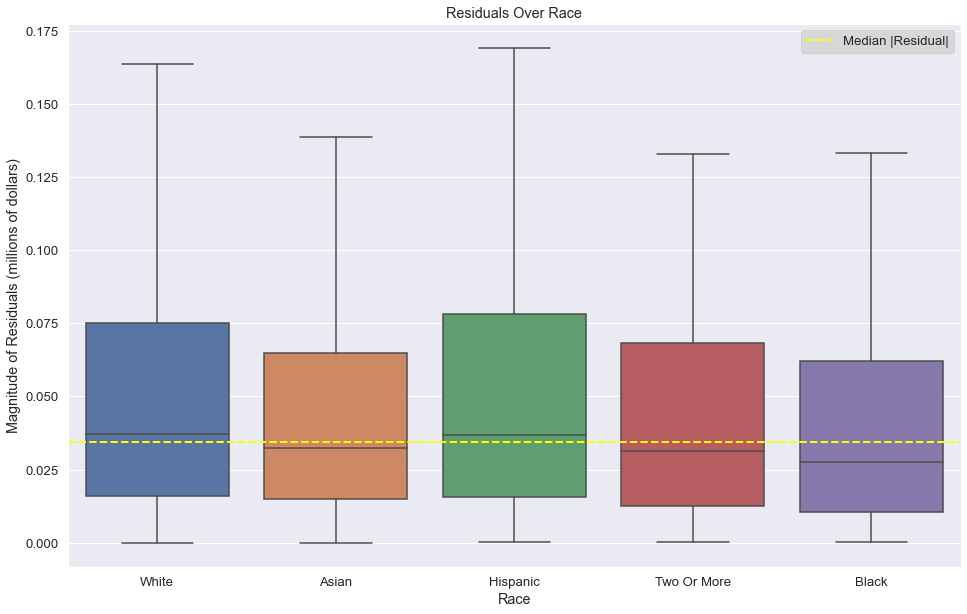

In [37]:
# Plotting magnitude of residuals over race 

plt.figure(figsize=(16,10))
race_plot = sns.boxplot(data=resultsdf, 
                        x='Race', 
                        y='residuals abs', 
                        showfliers = False,
                       ).set(title='Residuals Over Race') # title
plt.axhline(resultsdf['residuals abs'].median(), ls='--', color='yellow', lw = 2, alpha=1, label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Race") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis


In [39]:
# Precentage of occurances in the original dataframe
clean['Race'].value_counts()/ 21485 # diving by total number of rows

Asian          0.530277
White          0.355597
Hispanic       0.049430
Two Or More    0.033977
Black          0.030719
Name: Race, dtype: float64

Here we take a look at gender, as it turns out our model does a nearly identical job when predicting on Male as on Female.
> Plotting magnitude of residuals over gender, with a few alterations to make the plot more informative.


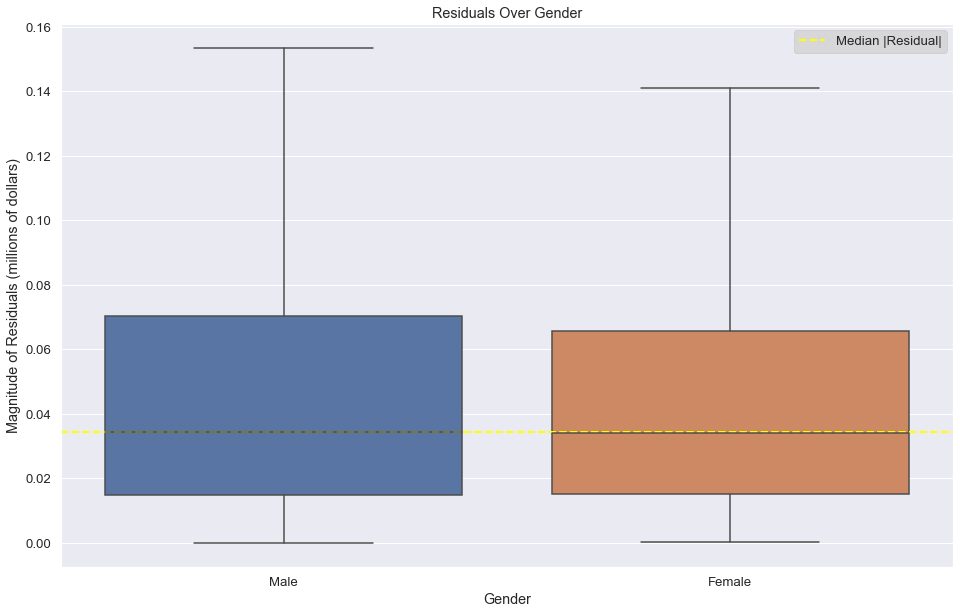

In [40]:
# Plotting magnitude of residuals over gender

plt.figure(figsize=(16,10))
race_plot = sns.boxplot(data=resultsdf, 
                        x='gender', 
                        y='residuals abs', 
                        showfliers = False,
                       ).set(title='Residuals Over Gender') # title
plt.axhline(resultsdf['residuals abs'].median(), ls='--', color='yellow', lw = 2, alpha=1, label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Gender") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis

In [42]:
# Precentage of occurances in the original dataframe
clean['gender'].value_counts()/ 21485

Male      0.819409
Female    0.180591
Name: gender, dtype: float64

Here we take a look at the highest earned education. For all except "PhD" our model fared similarly. 
> Plotting magnitude of residuals over education, with a few alterations to make the plot more informative.

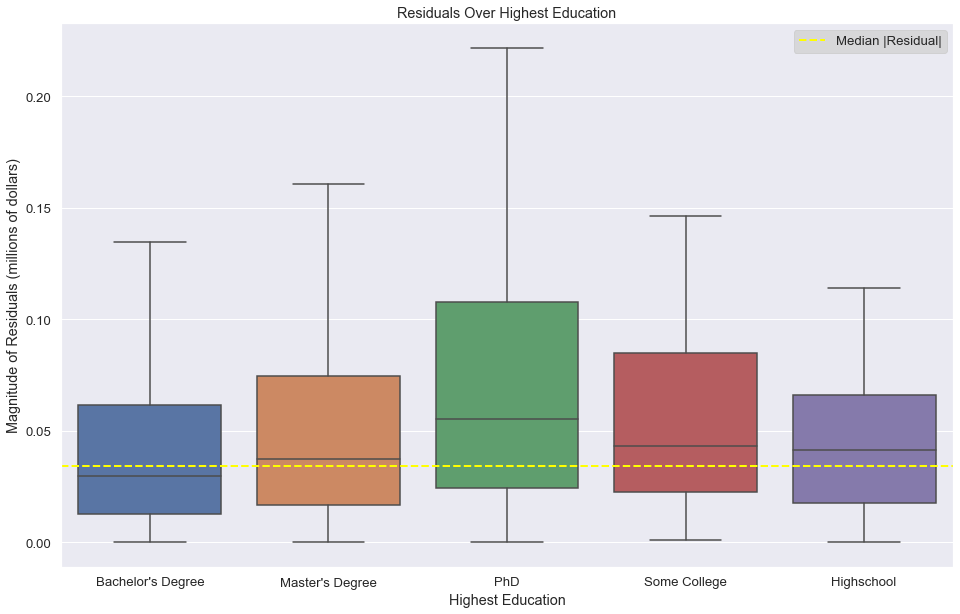

In [41]:
# Plotting magnitude of residuals over highest education
plt.figure(figsize=(16,10))
sns.boxplot(data=resultsdf, 
            x='Education', 
            y='residuals abs',
            showfliers = False
           ).set(title='Residuals Over Highest Education') # title
plt.axhline(resultsdf['residuals abs'].median(), ls='--', color='yellow', lw = 2, alpha=1,label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Highest Education") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis

In [ ]:
# Precentage of occurances in the original dataframe
clean['Education'].value_counts() / 21485

Here we take a look at job titles. It's here that we find for the majority of titles our model does a similar job, but for "software engineering manager" it does very poorly. This is very interesting considering that Software engineering mangers have the highest median pay amount all the titles in the dataset (as looked at in the graph below).
> Plotting magnitude of residuals over education, with a few alterations to make the plot more informative.


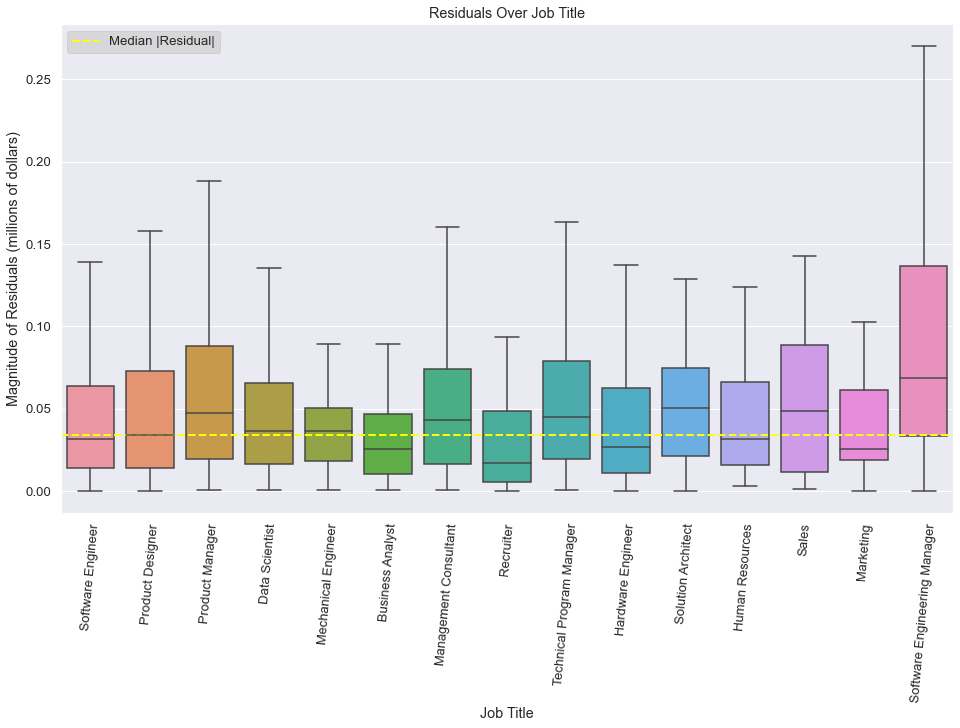

In [43]:
#  Plotting magnitude of residuals over job title 
plt.figure(figsize=(16,9))
chart = sns.boxplot(data=resultsdf, 
                    x='title', 
                    y='residuals abs',
                   showfliers = False
                   ).set(title='Residuals Over Job Title') # title
plt.axhline(resultsdf['residuals abs'].median(), ls='--', color='yellow', lw = 2, alpha=1, label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Job Title") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis
plt.xticks(
    rotation=85, size = 13);

As a continuation of the last graph we wanted to look at what titles make the most, just for a quick comparison.
It turns out that they are strikingly similar.
> Plotting total compensation over job title, with a few alterations to make the plot more informative.

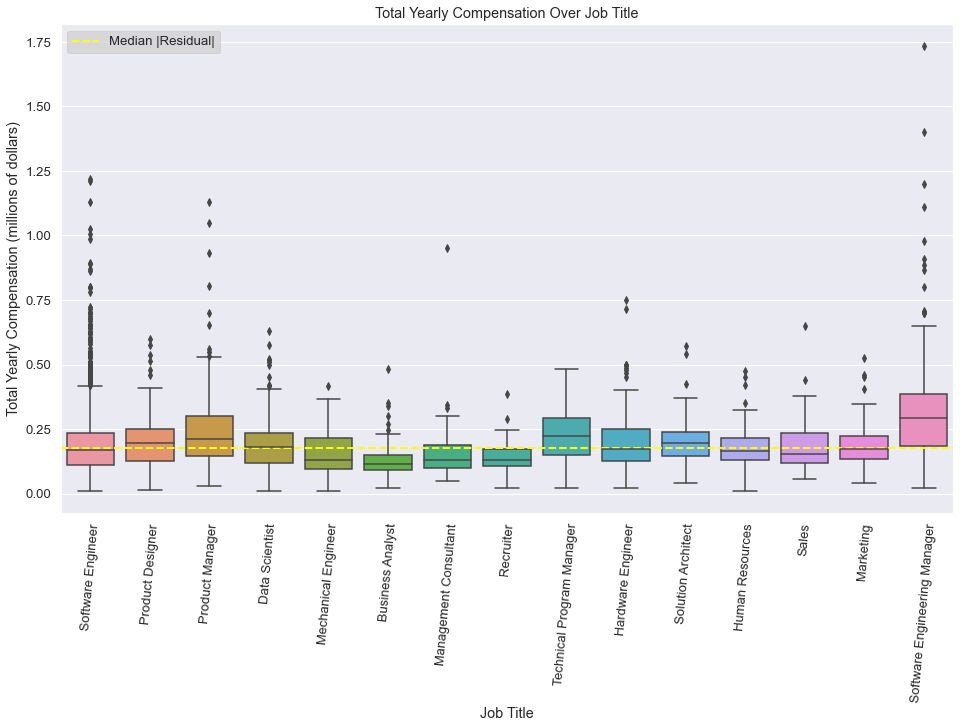

In [44]:
# Plotting total yearly compensation over job title 
plt.figure(figsize=(16,9))
chart = sns.boxplot(data=resultsdf, 
                    x='title', 
                    y='totalyearlycompensation',
                   showfliers = True,
                   ).set(title='Total Yearly Compensation Over Job Title') # title
plt.axhline(resultsdf['totalyearlycompensation'].median(), ls='--', color='yellow', lw = 2, alpha=1, label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Job Title") # label for x-axis
plt.ylabel("Total Yearly Compensation (millions of dollars)"); # label for y-axis
plt.xticks(
    rotation=85, size = 13);

In [45]:
# Precentage of occurances in the original dataframe
clean['title'].value_counts() / 21485

Software Engineer               0.634489
Product Manager                 0.067442
Software Engineering Manager    0.047289
Data Scientist                  0.040493
Hardware Engineer               0.036304
Technical Program Manager       0.029462
Product Designer                0.027647
Management Consultant           0.020945
Business Analyst                0.020666
Solution Architect              0.019037
Marketing                       0.016616
Mechanical Engineer             0.011869
Sales                           0.010100
Recruiter                       0.009960
Human Resources                 0.007680
Name: title, dtype: float64

In [46]:
import matplotlib.pyplot as plt

Here we take a look at countries. For the countries that have a large presence in our dataset the model does a fairly similar job, but for the countries with very few occurrences in our dataset our model does very poor.
> Plotting mangnitude of residuals over country, with a few alterations to make the plot more informative.

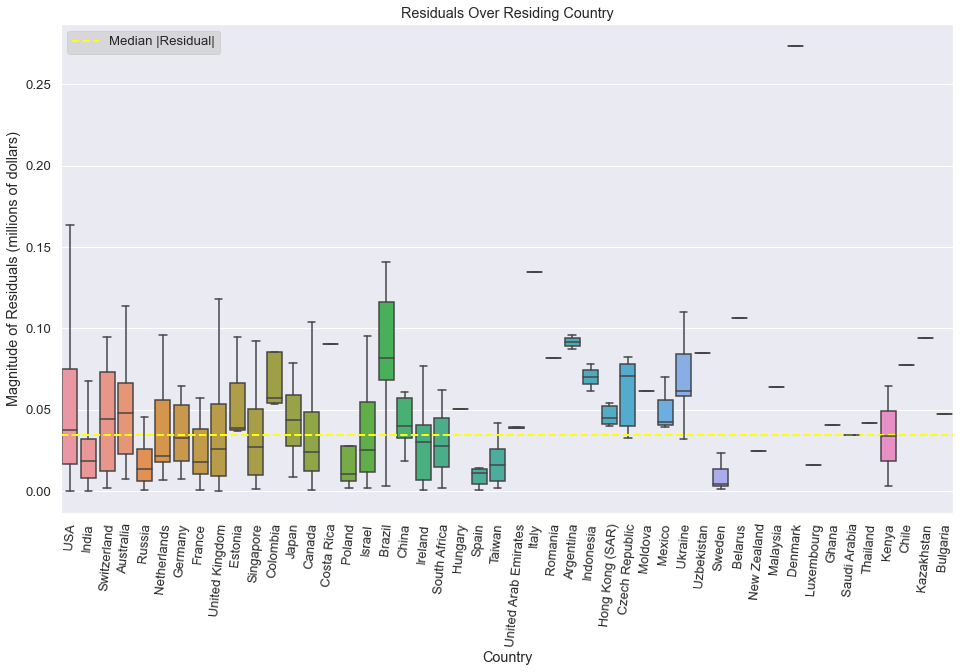

In [47]:
# Plotting magnitude of residuals over country
plt.figure(figsize=(16,9))
chart = sns.boxplot(data=resultsdf, 
                    x='country', 
                    y='residuals abs',
                   showfliers = False
                   ).set(title='Residuals Over Residing Country') # title
plt.axhline(resultsdf['residuals abs'].median(), ls='--', color='yellow', lw = 2, alpha=1, label = 'Median |Residual|')
plt.legend(facecolor = 'lightgray')
plt.xlabel("Country") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis
plt.xticks(
    rotation=85, size = 13);

In [48]:
# Precentage of occurances in the original dataframe
clean['country'].value_counts() / 21485

USA               0.785525
India             0.070980
Canada            0.036025
United Kingdom    0.024668
Germany           0.012474
                    ...   
Serbia            0.000047
Egypt             0.000047
Armenia           0.000047
Belgium           0.000047
Nigeria           0.000047
Name: country, Length: 65, dtype: float64

In [49]:
from scipy import stats

Here we took a look at the correlation between our residuals and total yearly compensation. Intrestingly we found a near perfectly positive correlation between the two. This tells us that as the total yearly compensation gets higher our model tends to make less accurate predictions. (for more information look to the blog post)
> Plotting magnitude of residuals over total yearly compensation, with a few alterations to make the plot more informative and easier to read.

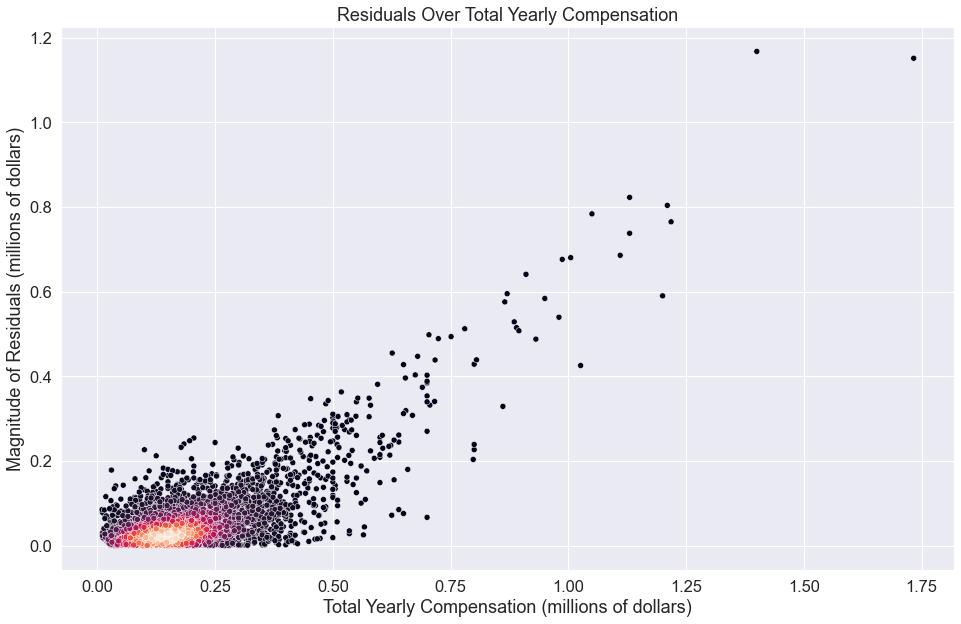

In [50]:
# Plotting maginitude of residuals over total yearly compensation
values = np.vstack([resultsdf['residuals abs'], resultsdf['totalyearlycompensation']]) # creating an array for the color gradient

kernel = stats.gaussian_kde(values)(values) # Creating the color gradient

plt.figure(figsize=(16,10)) # figure size

sns.set_theme(font_scale = 1.5) # font size

# Scatter plot
scatter = sns.scatterplot(
    data=resultsdf,
    y='residuals abs',
    x="totalyearlycompensation",
    c=kernel,
    cmap="rocket",
).set(title='Residuals Over Total Yearly Compensation') # title


plt.xlabel("Total Yearly Compensation (millions of dollars)") # label for x-axis
plt.ylabel("Magnitude of Residuals (millions of dollars)"); # label for y-axis

